<a href="https://colab.research.google.com/github/DanieelRC/RNyAP/blob/main/RodriguezCarreonDaniel_PT9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-codificadores

Rodriguez Carreón Daniel 12/12/2025

Los auto-codificadores (autoencoders) son redes que mapean una entrada a un espacio latente y lo devuelven al espacio de la entrada. La ventaja que proveen es que pueden representar una entrada como un conjunto de características (latentes); en muchas veces dichas características son menos que el espacio de entrada y por tanto podemos manipularlas de forma conceptual en lugar de su representación fenomenológica.

Un auto encoder se representa típicamente como:

$$
r = g(f(x)),
$$
donde $x$ es la entrada, $f$ una función codificadora (codificador), $g$ una función decodificadora (decodifricador) y $r$ la reconstrucción.


@SauloGante
@juan1rving

In [1]:
# Paquetes

import torch #para realizar operaciones con tensores es la libreria basica
import torchvision #Contiene paquetes para trabajar con datasets populares, arquitecturas e imagenes de vision computacional
import matplotlib.pyplot as plt
from matplotlib.pyplot      import close, figure, imshow, savefig, show, title
from matplotlib.lines       import Line2D
from os.path                import join
import numpy as np


In [2]:
# Verificar GPU

cuda_disponible = False
if torch.cuda.is_available():
    print("¿Esta el GPU disponible?: True")
    device = torch.cuda.current_device()
    print('Propiedades del dispositivo:', torch.cuda.get_device_properties(device))
    cuda_disponible = True
else:
    print("¿Esta el GPU disponible?: False")
    print("No hay GPU disponible")

¿Esta el GPU disponible?: False
No hay GPU disponible


## Datos

### Conjunto de Datos: MNIST

El conjunto de datos MNIST es una colección de 60,000 imágenes de dígitos manuscritos (0-9) en escala de grises, con una resolución de 28×28 píxeles. Es uno de los conjuntos de datos más utilizados en visión computacional y aprendizaje automático para tareas de clasificación y reconstrucción.

**Características principales:**
- **Tamaño del conjunto de entrenamiento:** 60,000 imágenes
- **Tamaño del conjunto de validación:** 10,000 imágenes
- **Resolución:** 28×28 píxeles
- **Formato:** Escala de grises (1 canal)
- **Origen:** Base de datos de dígitos manuscritos del NIST

### Preprocesamiento

El preprocesamiento se realiza mediante la transformación `img_transform`, que aplica dos operaciones:

1. **ToTensor():** Convierte las imágenes PIL a tensores de PyTorch con valores normalizados entre [0, 1].

2. **Normalize():** Normaliza los tensores con media 0.5 y desviación estándar 0.5, lo que centra los valores en el rango [-1, 1]. Esta normalización mejora la convergencia durante el entrenamiento.

### Uso en el Modelo

Después del preprocesamiento, el conjunto de datos se carga en dos DataLoaders:
- **dataloader:** Contiene el conjunto de entrenamiento con batch_size=512, utilizado para entrenar el autoencoder
- **dataloader_validacion:** Contiene el conjunto de validación con batch_size=10,000, utilizado para evaluar el rendimiento del modelo

Las imágenes se redimensionan de [1, 28, 28] a [batch_size, 784] (aplanadas) para pasarlas a través de las capas lineales del autoencoder.


In [3]:
img_transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5],[0.5])
])

In [4]:
dataset=torchvision.datasets.MNIST(root='./data', train=True, transform=img_transform, download=True)
print('Tamaño del conjunto de datos',len(dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.29MB/s]

Tamaño del conjunto de datos 60000


In [5]:
dataset_validacion =torchvision.datasets.MNIST(root='./data', train=False, transform=img_transform, download=True)
print('Tamaño del conjunto de datos de validación',len(dataset_validacion))

Tamaño del conjunto de datos de validación 10000


In [6]:
dataloader=torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)
dataloader_validacion = torch.utils.data.DataLoader(dataset_validacion, batch_size=10000, shuffle=True)

## Arquitectura

El autoencoder que se implementará consta de dos componentes principales:

### **Codificador (Encoder)**
Reduce la dimensionalidad de la entrada mediante capas lineales con activaciones ReLU:
- Entrada: 784 características (28×28 píxeles aplanados)
- Capa 1: 784 → 128 neuronas + ReLU
- Capa 2: 128 → 64 neuronas + ReLU
- Capa 3: 64 → 12 neuronas + ReLU
- Capa 4: 12 → 2 neurona (espacio latente)

### **Decodificador (Decoder)**
Reconstruye la imagen original desde el espacio latente mediante capas lineales simétricas:
- Entrada: 2 característica (vector latente)
- Capa 1: 1 → 12 neuronas + ReLU
- Capa 2: 12 → 64 neuronas + ReLU
- Capa 3: 64 → 128 neuronas + ReLU
- Capa 4: 128 → 784 neuronas + Tanh
- Salida: 784 características (imagen reconstruida)

### **Características principales**
- **Espacio latente:** 1 dimensión, que captura la información esencial de los dígitos MNIST
- **Función de activación del decoder:** Tanh comprime la salida al rango [-1, 1], consistente con la normalización aplicada a los datos de entrada
- **Arquitectura simétrica:** El decoder refleja la estructura del encoder, asegurando una reconstrucción coherente


In [7]:
class autoencoder(torch.nn.Module):

    def __init__(self):
        super(autoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(True),

            torch.nn.Linear(128,64),
            torch.nn.ReLU(True),

            torch.nn.Linear(64,12),
            torch.nn.ReLU(True),

            torch.nn.Linear(12,2),
            torch.nn.Tanh())  # Función tanh para mantener el espacio latente entre -1 y 1

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2,12),
            torch.nn.ReLU(True),

            torch.nn.Linear(12,64),
            torch.nn.ReLU(True),

            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True),

            torch.nn.Linear(128, 28*28),
            torch.nn.Tanh())
        self.encode = True
        self.decode = True

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Entrenamiento

El proceso de entrenamiento del autoencoder utiliza el conjunto de datos de entrenamiento (`dataloader`) con 60,000 imágenes MNIST. En cada época:

1. **Entrada al modelo:** Las imágenes se aplanan de [batch_size, 1, 28, 28] a [batch_size, 784] para pasar a través de las capas lineales del encoder.

2. **Reconstrucción:** El modelo procesa la entrada a través del encoder (comprimiendo a 1 dimensión) y luego del decoder (reconstruyendo a 784 características).

3. **Comparación con valores esperados:** Se utiliza la función de pérdida MSE (Error Cuadrático Medio) para comparar la imagen reconstruida con la imagen original de entrada. Esta métrica mide qué tan bien el modelo puede reproducir la entrada después de pasar por el espacio latente.

4. **Optimización:** El optimizador Adam ajusta los pesos del modelo para minimizar esta diferencia de reconstrucción en cada iteración.

5. **Validación:** Después de cada época, el modelo se evalúa en el conjunto de validación (`dataloader_validacion`) con 10,000 imágenes para monitorear el rendimiento y evitar sobreajuste.

El objetivo es que el autoencoder aprenda a comprimir y reconstruir las imágenes MNIST de manera efectiva, capturando las características esenciales de los dígitos en el espacio latente de 1 dimensión.

In [8]:
model = autoencoder()
if torch.cuda.is_available():
    model = model.cuda()
else:
    print("GPU no disponible. Usando CPU.")

GPU no disponible. Usando CPU.


In [9]:
# Entrenamiento
# Entradas: Dataset, modelo, funciondeperdida, optimizador
# Salidas: Error
def entrena(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for batch, (X,y) in enumerate(dataloader):
        img = X
        img = img.view(img.size(0), -1)
        img = img.to(device)

        #=============forward==================
        output = model(img)
        loss = loss_fn(output, img)

        #=============backward=================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [10]:
#Validación
# Entradas: Dataset, modelo, funciondeperdida
# Salidas: Error_promedio
def valida(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    loss = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for data in dataloader:
            img, _ = data
            img = img.view(img.size(0), -1)
            img = img.to(device)
            prediccion = model(img)
            test_loss = loss_fn(prediccion, img)
            loss += test_loss.item()

    loss /= num_batches
    return loss

In [11]:
num_epochs= 10 #Numero de épocas
criterion= torch.nn.MSELoss() #Metrica error
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9)

loss_ant = 10.0
losses = {"entrenamiento":[], "validación":[]}
mejor = 0

for epoch in range(num_epochs):

    print(f"Época {epoch+1}\n-------------------------------")
    loss_entrena = entrena(dataloader, model, criterion, optimizer)
    loss_valida = valida(dataloader_validacion, model, criterion)
    #============save_weights==============
    losses["entrenamiento"].append(loss_entrena.item())
    losses["validación"].append(loss_valida)

    if loss_entrena.item() < loss_ant:
        torch.save(model.state_dict(), 'weights_entrenamiento_autoencMNIST.pth')
        loss_ant = loss_entrena.item()
        mejor = epoch
        print(f"Pérdida de entrenamiento: {loss_ant:.3f}")

    #================log========================
    if epoch % 10 == 0:
        loss_value=loss_entrena.cpu().detach().numpy()
        print(f"Pérdida de validación: {loss_value:.3f}")

print('Final:\n')
print(f"Mejor época: {mejor+1}")
print(f"Número de épocas: {epoch+1}")
print(f"Pérdida entrenamiento: {loss_entrena.item():.3f}")
print(f"Pérdida validación: {loss_valida:.3f}")

Época 1
-------------------------------
Pérdida de entrenamiento: 0.828
Pérdida de validación: 0.828
Época 2
-------------------------------
Pérdida de entrenamiento: 0.349
Época 3
-------------------------------
Pérdida de entrenamiento: 0.293
Época 4
-------------------------------
Pérdida de entrenamiento: 0.272
Época 5
-------------------------------
Pérdida de entrenamiento: 0.269
Época 6
-------------------------------
Pérdida de entrenamiento: 0.266
Época 7
-------------------------------
Época 8
-------------------------------
Pérdida de entrenamiento: 0.263
Época 9
-------------------------------
Época 10
-------------------------------
Pérdida de entrenamiento: 0.252
Final:

Mejor época: 10
Número de épocas: 10
Pérdida entrenamiento: 0.252
Pérdida validación: 0.269


#### Graficación del entrenamiento

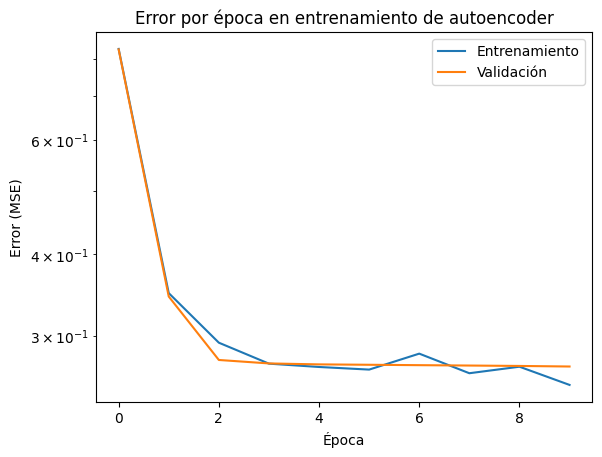

In [12]:
# Plot losses
plt.figure()
plt.semilogy(losses['entrenamiento'], label='Entrenamiento')
plt.semilogy(losses['validación'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.legend()
plt.title('Error por época en entrenamiento de autoencoder')
plt.show()

In [13]:
torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_entrena.item()
},

'MNIST_autoencoder.pth')

## Resultados

In [14]:
# Determinar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear modelo y moverlo al dispositivo
model_test = autoencoder().to(device)

# Cargar pesos entrenados
checkpoint_test = torch.load('weights_entrenamiento_autoencMNIST.pth')
model_test.load_state_dict(checkpoint_test)
model_test.eval()

print(f"Modelo cargado en: {device}")
model_test.eval()

Modelo cargado en: cpu


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

(np.float64(-0.5), np.float64(1.5), np.float64(0.5), np.float64(-0.5))

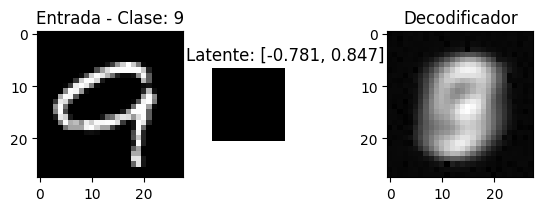

In [18]:
# Ejemplo aleatorio
input_, label = dataset[np.random.randint(0, len(dataset))]

#procesamiento dato de entrada
input_test = input_.view(input_.size(0), -1)
output_test=model_test(input_test)
code_output=model_test.encoder(input_test)

#procesamiento dato de salida de autoencoder
output_test=output_test.reshape(28,28)
output_test=output_test.detach().numpy()

#procesamiento de dato salida del codificador - ahora son 2 dimensiones
img_code=code_output.reshape(1,2)
img_code=img_code.detach().numpy()


#Visualización
plt.subplot(1, 3, 1)
plt.imshow(input_.numpy()[0], cmap='gray')
plt.title(f"Entrada - Clase: {label}")

plt.subplot(1, 3, 3)
plt.imshow(output_test, cmap='gray')
plt.title("Decodificador")

plt.subplot(1, 3, 2)
# Crear imagen 1x2 con los dos valores latentes

latent_img = img_code.reshape(1, 2)
plt.imshow(latent_img, cmap='gray')
plt.title(f'Latente: [{img_code[0,0]:.3f}, {img_code[0,1]:.3f}]')
plt.axis('off')

## Graficos de espacio latente


In [19]:
datos = {"codificado_x":[], "codificado_y":[], "etiqueta":[]}  # Cambio para almacenar ambas dimensiones
dataiter = iter(dataloader_validacion)
images, labels = next(dataiter)
images = images.view(images.size(0), -1)
encoded_features = model_test.encoder(images)
for i in range (len(encoded_features)):
    # Ahora extraemos ambas dimensiones del espacio latente
    datos['codificado_x'].append(encoded_features[i][0].item())  # Primera dimensión
    datos['codificado_y'].append(encoded_features[i][1].item())  # Segunda dimensión
    datos['etiqueta'].append(labels[i])

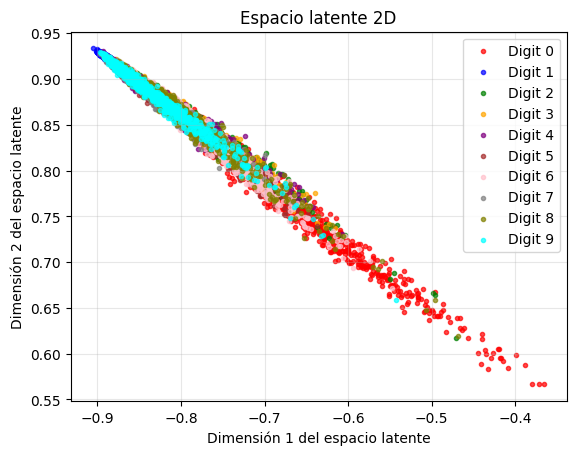

In [20]:
# plot - ahora es un scatter plot 2D
fig, ax = plt.subplots()

# Crear un scatter plot con colores diferentes para cada etiqueta
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for digit in range(10):
    # Filtrar puntos para cada dígito
    x_digit = [datos["codificado_x"][i] for i in range(len(datos["etiqueta"])) if datos["etiqueta"][i] == digit]
    y_digit = [datos["codificado_y"][i] for i in range(len(datos["etiqueta"])) if datos["etiqueta"][i] == digit]
    ax.scatter(x_digit, y_digit, c=colors[digit], label=f'Digit {digit}', marker='.', alpha=0.7)

ax.set(xlabel='Dimensión 1 del espacio latente', ylabel='Dimensión 2 del espacio latente')
ax.legend()
plt.title("Espacio latente 2D")
plt.grid(True, alpha=0.3)
plt.show()

## Asignación

(4 puntos) Modifica el código anterior para que auto-codificar mejore su desempeño. De tal forma que reconstruya bien los números y en la gárica del espacio latente se muestre una separación evidente de las clases. Toma como ejemplo la imagen del paper de Hinton.

<img src="./archivos/313_504_f3.jpeg" alt="Texto alternativo" width="500" height="300">


En esta figura se muestra en la derecha como se separan las clases en el espacio latente. Tu entrenamiento debe llegar a algo similar. Reporta abajo tu diseño experimental que realizaste y tus hallazos.

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# CONFIGURACIÓN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 2
BATCH = 128
LR = 1e-3
EPOCHS = 40
LAMBDA = 1.0
os.makedirs("resultados_unicos", exist_ok=True)

# DATASET (MNIST)
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST("data", train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST("data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False)

# MODELO
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 2, 1)  # 32x14x14
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1) # 64x7x7
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, LATENT_DIM)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        z = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(LATENT_DIM, 64*7*7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1,  3, 2, 1, output_padding=1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

class Modelo(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.classifier = nn.Sequential(
            nn.Linear(LATENT_DIM, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        logits = self.classifier(z)
        return recon, logits, z

model = Modelo().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)

# FUNCIONES DE ENTRENAMIENTO
def evaluar(model):
    model.eval()
    zs, ys = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            recon, logit, z = model(x)
            zs.append(z.cpu().numpy())
            ys.append(y.numpy())
    return np.concatenate(zs), np.concatenate(ys)

# ENTRENAMIENTO
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        opt.zero_grad()
        recon, logits, z = model(x)

        # Pérdidas
        loss_recon = F.mse_loss(recon, x)
        loss_cls   = F.cross_entropy(logits, y)
        loss = loss_recon + LAMBDA * loss_cls

        loss.backward()
        opt.step()
        total_loss += loss.item()

    print(f"[{epoch}/{EPOCHS}] Loss: {total_loss/len(train_loader):.4f}")

# EVALUACIÓN Y GRAFICADO
zs, ys = evaluar(model)

plt.figure(figsize=(8,8))
scatter = plt.scatter(zs[:,0], zs[:,1], c=ys, cmap="tab10", s=8)
plt.title("Espacio latente 2D (λ = 1.0)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.colorbar(scatter)
plt.savefig("resultados_unicos/espacio_latente.png", dpi=150)
plt.close()

print("Finalizado. Imagen guardada en resultados_unicos/espacio_latente.png")


[1/40] Loss: 0.9979
[2/40] Loss: 0.3889
[3/40] Loss: 0.2455
[4/40] Loss: 0.1899
[5/40] Loss: 0.1593
[6/40] Loss: 0.1370
[7/40] Loss: 0.1201
[8/40] Loss: 0.1062
[9/40] Loss: 0.0980
[10/40] Loss: 0.0919
[11/40] Loss: 0.0874
[12/40] Loss: 0.0819
[13/40] Loss: 0.0760
[14/40] Loss: 0.0750
[15/40] Loss: 0.0704
[16/40] Loss: 0.0689
[17/40] Loss: 0.0661
[18/40] Loss: 0.0650
[19/40] Loss: 0.0648
[20/40] Loss: 0.0610
[21/40] Loss: 0.0615
[22/40] Loss: 0.0614
[23/40] Loss: 0.0593
[24/40] Loss: 0.0603
[25/40] Loss: 0.0593
[26/40] Loss: 0.0568
[27/40] Loss: 0.0556
[28/40] Loss: 0.0601
[29/40] Loss: 0.0569
[30/40] Loss: 0.0552
[31/40] Loss: 0.0559
[32/40] Loss: 0.0539
[33/40] Loss: 0.0539
[34/40] Loss: 0.0549
[35/40] Loss: 0.0579
[36/40] Loss: 0.0511
[37/40] Loss: 0.0514
[38/40] Loss: 0.0518
[39/40] Loss: 0.0511
[40/40] Loss: 0.0524
Finalizado. Imagen guardada en resultados_unicos/espacio_latente.png


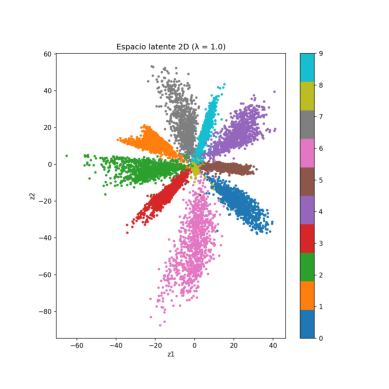

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
ruta = "./resultados_unicos/espacio_latente.png"
img = mpimg.imread(ruta)
plt.imshow(img)
plt.axis('off')
plt.show()